In [ ]:
# author: Carlos F. Dietrich (carlos.dietrich@tum.de)
# reviewer: Francisco J. Guerrero-Gonzalez
# version: 1.0.0

Copyright 2023, Professorship of Lunar and Planetary Exploration, Technical University of Munich.

Permission is hereby granted, free of charge, to any person obtaining a copy of this model and associated documentation files, without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the models, and to permit persons to whom the model is furnished to do so, subject to the following conditions:

1. The above copyright notice and this permission notice shall be included in all copies or substantial portions of the model, as well as reference to the author(s) listed above. Scientific publications which use this model shall cite the [ISRULib documentation site](https://wiki.tum.de/display/lpe/ISRULib) attributing credit to the named authors in the documentation.

2. The model is provided without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose, and non-infringement. In no event shall the authors or copyright holders be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the model or the use or other dealings in the model.

# High-Pressure Storage

In [1]:
# Python Libraries
import numpy as np
import matplotlib.pyplot as plt

from sympy import *
from IPython import display
from scipy.optimize import fsolve 

**Model Description**

High-pressure storage model aims to estimate the required tank mass for gas storage at elevated pressures. Higher pressures reduce the required tank volume.  Different gasses are modelled by correspondigly adapting their molecular weights. 

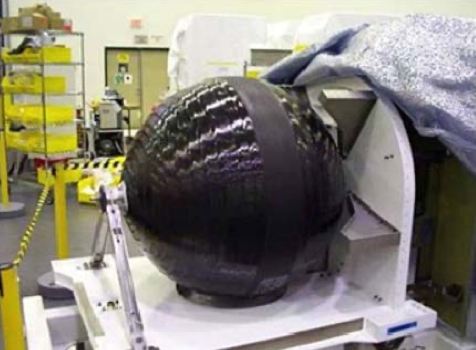

In [2]:
# Include here a descriptive figure of the component (model)
display.Image("figs/tank.png") # The image shows a high-pressure tank flown on the Space Shuttle (NASA, 2009)

**Model Assumptions, Simplifications and future Improvements**

For comparison, all gases are assumed to be ideal gases.


The tank diameter is assumed to be the same for all gases and can be changed accordingly in the model. The tank is assumed to sperical. The model only considers the tank mass and disregards structural mass, insulation & hardware mass required for cooling. A safety factor is included which can be adapted to the desired margin. 

The temperature of the gases is assumed to be constant and can be changed accordingly.

The tank material and gas pressure can be selected for each gas in *Table 1* (see **1. Inputs**). The available gasses within the model are O<sub>2</sub>, H<sub>2</sub>, CO, CO<sub>2</sub>, N<sub>2</sub>, and CH<sub>4</sub>. For simplification, it is assumed that the tank is made of a single material. The material properties are proximates. 

The material properties, such as strength, are dependent on the temperature and on the manufacturing process. These effects are neglected as the properies are seleceted from exising tanks operative in low temperatures, and the resulting deviations due to small temperature changes are expected to be small. 

The model is designed so that additional tank materials, and stored gases can be added. 

Future improvements could include:
- Adding additional tank materials, e.g., hybrid materials
- Adding additional gases
- Include more detailed data about performance of materials and tanks depending on manufacturing process
- Include supporting structural mass and insulation
- Include cooling mechanisms

The rest of the assumptions and possible improvements are explained thoroughly in **3. Model Body**.

## 1. Inputs

In [3]:
tank_outer_diameter = 1 # m | Tank outer diameter (Boundry Condition -> can be adapted to mission)
safety_factor = 2 # - | Safety factor, also used on other tanks, see source (Benedic et al., 2005)

# Gas Temperatures are considered from Tank conditions from (MT Aerospace_b), and can be adapted to the desired application:
T_O2  = 240 # K | Oxygen temperature 
T_H2  = 240 # K | Hydrogen temperature
T_CO  = 240 # K | Carbon monoxide temperature
T_CO2 = 240 # K | Carbon dioxide temperature 
T_N2  = 240 # K | Nitrogen temperature 
T_CH4 = 240 # K | Methane temperature 

# Selection of operating pressure dependent on gas and tank material. Values in Table 1 can be adapted to the desired application: 
Table1 = [
    ['Gas','Pressure in bar','Tank Material'],
    
    ['O2',  280, 'Carbon/Epoxy CFK'], # (MT Aerospace_a)
    ['H2',  310, 'Carbon/Epoxy CFK'], # (MT Aerospace_b)
    ['CO',  280, 'Carbon/Epoxy CFK'], # (MT Aerospace_a), assuming same as oxygen
    ['CO2', 280, 'Carbon/Epoxy CFK'], # (MT Aerospace_a), assuming same as oxygen
    ['N2',  280, 'Carbon/Epoxy CFK'], # (MT Aerospace_a)
    ['CH4', 280, 'Carbon/Epoxy CFK']  # (MT Aerospace_a), assuming same as oxygen
    ]

# Tank Material properties:
# Sigma Allow is the allowable strength in N/mm^2 
# RhoTank is the material density in kg/m^3
# Table 2 matches the tanks properties to the selected material. It can be adapted for other material properties if desired.
Table2 = [
    ['Tank Material','Sigma Allow','RhoTank', 'i'],
    
    ['Ultrafort 101',    800, 7850], # Expert estimation (TUM Chair of Space Propulsion)
    ['Ti6AlV4',          498, 4450], # Expert estimation (TUM Chair of Space Propulsion)
    ['Glass/Epoxy GFK',  867, 2000], # Expert estimation (TUM Chair of Space Propulsion)
    ['Carbon/Epoxy CFK', 808, 1800], # (Nettles & Biss, 1996)
    ['Kevlar/Epoxy KFK', 932, 1900], # Expert estimation (TUM Chair of Space Propulsion)
    ['AlZnMg1',          168, 2800], # Expert estimation (TUM Chair of Space Propulsion)
    ['AlSl 347',         165, 7800]  # Expert estimation (TUM Chair of Space Propulsion)
    ] 

## 2. Constants

In [4]:
pi = np.pi # -

Rm = 8.314 # J/(mol-K) | Universal gas constant

mO2  = 32e-3 # kg/mol | Molecular mas of oxygen
mH2  = 2e-3  # kg/mol | Molecular mas of hydrogen
mCO  = 28e-3 # kg/mol | Molecular mas of carbon monoxide
mCO2 = 44e-3 # kg/mol | Molecular mas of carbon dioxide
mN2  = 28e-3 # kg/mol | Molecular mas of nitrogen
mCH4 = 16e-3 # kg/mol | Molecular mas of methane

R_O2  = Rm/mO2  # J/(kg-K) | Ideal gas constant of oxygen
R_H2  = Rm/mH2  # J/(kg-K) | Ideal gas constant of hydrogen
R_CO  = Rm/mCO  # J/(kg-K) | Ideal gas constant of carbon monoxide
R_CO2 = Rm/mCO2 # J/(kg-K) | Ideal gas constant of carbon dioxide
R_N2  = Rm/mN2  # J/(kg-K) | Ideal gas constant of nitrogen
R_CH4 = Rm/mCH4 # J/(kg-K) | Ideal gas constant of methane

## 3. Model Body

In [5]:
# Convert tank pressure from bar to Pa
p_O2  = (Table1[1][1])*10**5 # Pa | Tank gas pressure for oxygen
p_H2  = (Table1[2][1])*10**5 # Pa | Tank gas pressure for hydrogen
p_CO  = (Table1[3][1])*10**5 # Pa | Tank gas pressure for carbon monoxide
p_CO2 = (Table1[4][1])*10**5 # Pa | Tank gas pressure for carbon dioxide
p_N2  = (Table1[5][1])*10**5 # Pa | Tank gas pressure for nitrogen
p_CH4 = (Table1[6][1])*10**5 # Pa | Tank gas pressure for methane

# Combine entries from Table 1 and 2
# sigma_Gas is the allowable strength in Pa
# Rho_tank_Gas is density of tank the material

# Oxygen
for i in range(0,7,1):
    if Table1[1][2] == Table2[i][0]:
        sigma_O2 = Table2[i][1]*10**6 # Pa
        Rho_tank_02 = Table2[i][2] # kg/m3
        break         

# Hydrogen
for i in range(0,7,1):
    if Table1[2][2] == Table2[i][0]:
        sigma_H2 = Table2[i][1]*10**6 # Pa
        Rho_tank_H2 = Table2[i][2] # kg/m3
        break

# Carbon monoxide
for i in range(0,7,1):
    if Table1[3][2] == Table2[i][0]:
        sigma_CO = Table2[i][1]*10**6 # Pa
        Rho_tank_CO = Table2[i][2] # kg/m3
        break 

# Carbon dioxide
for i in range(0,7,1):
    if Table1[4][2] == Table2[i][0]:
        sigma_CO2 = Table2[i][1]*10**6 # Pa
        Rho_tank_CO2 = Table2[i][2] # kg/m3
        break

# Nitrogen
for i in range(0,7,1):
    if Table1[5][2] == Table2[i][0]:
        sigma_N2 = Table2[i][1]*10**6 # Pa
        Rho_tank_N2 = Table2[i][2] # kg/m3
        break

# Methane
for i in range(0,7,1):
    if Table1[6][2] == Table2[i][0]:
        sigma_CH4 = Table2[i][1]*10**6 # Pa
        Rho_tank_CH4 = Table2[i][2] # kg/m3
        break 

# Wall thickness of tank
# The mininum wall thickes of the tank (tmin) is calculated using Barlow's spherical formula:
# tmin = safety_factor*pmax*tank_outer_diameter/(4*sigma), where
# safety_factor is the safety factor
# pmax is the maximum allowable pressure in Pa
# tank_outer_diameter is the tank outer diameter in m
# sigma is the maximum allowable stress in Pa
tmin_O2  = (p_O2*tank_outer_diameter/(4*sigma_O2))*safety_factor # m
tmin_H2  = (p_H2*tank_outer_diameter/(4*sigma_H2))*safety_factor # m
tmin_CO  = (p_CO*tank_outer_diameter/(4*sigma_CO))*safety_factor # m
tmin_CO2 = (p_CO2*tank_outer_diameter/(4*sigma_CO2))*safety_factor # m
tmin_N2  = (p_N2*tank_outer_diameter/(4*sigma_N2))*safety_factor # m
tmin_CH4 = (p_CH4*tank_outer_diameter/(4*sigma_CH4))*safety_factor # m

# Tank mass (m_tank) for an spherical tank:
# m_tank = (4/3*pi*(tank_outer_diameter/2)**3 - 4/3*pi*((tank_outer_diameter-2*tmin)/2)**3)*Rho in kg
m_tank_O2  = (4/3*pi*(tank_outer_diameter/2)**3 - 4/3*pi*((tank_outer_diameter-2*tmin_O2)/2)**3)*Rho_tank_02 # kg
m_tank_H2  = (4/3*pi*(tank_outer_diameter/2)**3 - 4/3*pi*((tank_outer_diameter-2*tmin_H2)/2)**3)*Rho_tank_H2 # kg
m_tank_CO  = (4/3*pi*(tank_outer_diameter/2)**3 - 4/3*pi*((tank_outer_diameter-2*tmin_CO)/2)**3)*Rho_tank_CO # kg
m_tank_CO2 = (4/3*pi*(tank_outer_diameter/2)**3 - 4/3*pi*((tank_outer_diameter-2*tmin_CO2)/2)**3)*Rho_tank_CO2 # kg
m_tank_N2  = (4/3*pi*(tank_outer_diameter/2)**3 - 4/3*pi*((tank_outer_diameter-2*tmin_N2)/2)**3)*Rho_tank_N2 # kg
m_tank_CH4 = (4/3*pi*(tank_outer_diameter/2)**3 - 4/3*pi*((tank_outer_diameter-2*tmin_CH4)/2)**3)*Rho_tank_CH4 # kg

# Volume inside tank in m3:
V_O2  = 4/3*pi*(((tank_outer_diameter-2*tmin_O2)/2)**3) # m3
V_H2  = 4/3*pi*(((tank_outer_diameter-2*tmin_H2)/2)**3) # m3
V_CO  = 4/3*pi*(((tank_outer_diameter-2*tmin_CO)/2)**3) # m3
V_CO2 = 4/3*pi*(((tank_outer_diameter-2*tmin_CO2)/2)**3) # m3
V_N2  = 4/3*pi*(((tank_outer_diameter-2*tmin_N2)/2)**3) # m3
V_CH4 = 4/3*pi*(((tank_outer_diameter-2*tmin_CH4)/2)**3) # m3

# Gas mass (mGas_XX) inside the tank follows the ideal gas law: m = pV/(RT)
mGas_O2  = p_O2*V_O2/(R_O2*T_O2) # kg
mGas_H2  = p_H2*V_H2/(R_H2*T_H2) # kg
mGas_CO  = p_CO*V_CO/(R_CO*T_CO) # kg
mGas_CO2 = p_CO2*V_CO2/(R_CO2*T_CO2) # kg
mGas_N2  = p_N2*V_N2/(R_N2*T_N2) # kg
mGas_CH4 = p_CH4*V_CH4/(R_CH4*T_CH4) # kg

# Performance metric: kg of tank per kg of gas (kg/kg)
performance_O2  = m_tank_O2/mGas_O2 # kg/kg
performance_H2  = m_tank_H2/mGas_H2 # kg/kg
performance_CO  = m_tank_CO/mGas_CO # kg/kg
performance_CO2 = m_tank_CO2/mGas_CO2 # kg/kg
performance_N2  = m_tank_N2/mGas_N2 # kg/kg
performance_CH4 = m_tank_CH4/mGas_CH4 # kg/kg

## 4. Outputs

In [11]:
print("O\u2082: ", round(performance_O2,3), "kg tank per kg gas")
print("H\u2082: ", round(performance_H2,3), "kg tank per kg gas")
print("CO: ", round(performance_CO,3), "kg tank per kg gas")
print("CO\u2082:", round(performance_CO2,3), "kg tank per kg gas")
print("N\u2082: ", round(performance_N2,3), "kg tank per kg gas")
print("CH\u2084:", round(performance_CH4,3), "kg tank per kg gas")

O₂:  0.447 kg tank per kg gas
H₂:  7.214 kg tank per kg gas
CO:  0.511 kg tank per kg gas
CO₂: 0.325 kg tank per kg gas
N₂:  0.511 kg tank per kg gas
CH₄: 0.895 kg tank per kg gas


## References

F. Benedic, J.-P. Leard, C. Lefloch, Helium High Pressure Tanks at EADS Space Transportation New Technology with Thermoplastic, Tech. Rep. ADA445482, 2005, URL https://apps.dtic.mil/sti/pdfs/ADA445482.pdf

MT Aerospace_a, PVG-132: O<sub>2</sub>, N<sub>2</sub>, Air Storage Tank, Tech. Rep., URL https://www.mt-aerospace.de/files/mta/tankkatalog/Datenblatt_PVG-132.pdf

MT Aerospace_b, Spacecraft Propellant Tanks, Tech. Rep., https://www.mt-aerospace.de/files/mta/tankkatalog/MT-Tankkatalog.pdf

NASA, Space Shuttle Mission STS-129: Stocking the Station (Press Kit), 2009, URL https://www.nasa.gov/pdf/397216main_sts129_presskit.pdf

A. T. Nettles, E. J. Biss, Low Temperature Mechanical Testing of Carbon-Fiber/Expoxy-REsin Composite Materials, Tech. Rep. 3662, NASA, 1996, URL https://indico.fnal.gov/event/12288/contributions/13221/attachments/8718/11123/NASA_Technical_Paper_3663.pdf

TUM Chair of Space Propulsion, URL https://www.asg.ed.tum.de/en/spm/homepage/